In [1]:
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

2024-03-07 10:36:12.542297: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv("../data/cleaned_data.csv")
data.head()

,id,text,target
0,48,wholesale markets ablaze,1
1,49,we always try to bring the heavy,0
2,50,breaking news nigeria flag set ablaze in aba,1
3,52,crying out for more set me ablaze,0
4,53,on plus side look at the sky last night it was...,0


Text(0, 0.5, 'Total samples')

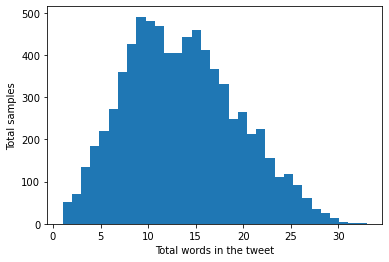

In [11]:
seq_len = [len(x.split()) for x in data.text.tolist()]
plt.hist(seq_len, bins=33);
plt.xlabel("Total words in the tweet")
plt.ylabel("Total samples")

In [520]:
X = data.text
y = data.target

## Basic model

In [521]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GlobalAveragePooling1D, Flatten, LSTM, InputLayer
from tensorflow.keras.optimizers import Optimizer, Adam
from tensorflow.keras.callbacks import EarlyStopping

In [457]:
UNIQUE_WORD_COUNT = 12861
tokenizer = Tokenizer(num_words=UNIQUE_WORD_COUNT, char_level=False)
tokenizer.fit_on_texts(X)

In [458]:
MAX_SEQUENCE = 147
X_data = tokenizer.texts_to_sequences(X)
X_data = pad_sequences(X_data, maxlen=MAX_SEQUENCE, padding='post')

In [459]:
y_data = to_categorical(y)

In [460]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=41)

In [416]:
X_train = (X_train - np.min(X_train))/(np.max(X_train) - np.min(X_train))
X_val = (X_val - np.min(X_val))/(np.max(X_val) - np.min(X_val))

In [417]:
X_train.shape

(6041, 147)

In [428]:
simple_model = Sequential()
simple_model.add(Dense(1024, activation='relu', input_shape=(X_train.shape[1],)))
simple_model.add(Dropout(0.3))
simple_model.add(Dense(512, activation='relu'))
simple_model.add(Dense(64, activation='relu'))
simple_model.add(Dense(2, activation='softmax'))

In [429]:
adam = Adam(learning_rate=0.001)
simple_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

In [430]:
simple_model.summary()

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_304 (Dense)           (None, 1024)              151552    
                                                                 
 dropout_57 (Dropout)        (None, 1024)              0         
                                                                 
 dense_305 (Dense)           (None, 512)               524800    
                                                                 
 dense_306 (Dense)           (None, 64)                32832     
                                                                 
 dense_307 (Dense)           (None, 2)                 130       
                                                                 
Total params: 709314 (2.71 MB)
Trainable params: 709314 (2.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [432]:
history = simple_model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_val, y_val), verbose=True)

Epoch 1/2
189/189 [==============================] - 2s 9ms/step - loss: 0.6384 - acc: 0.6348 - val_loss: 0.6674 - val_acc: 0.6228
Epoch 2/2
189/189 [==============================] - 2s 8ms/step - loss: 0.6265 - acc: 0.6532 - val_loss: 0.6608 - val_acc: 0.6228


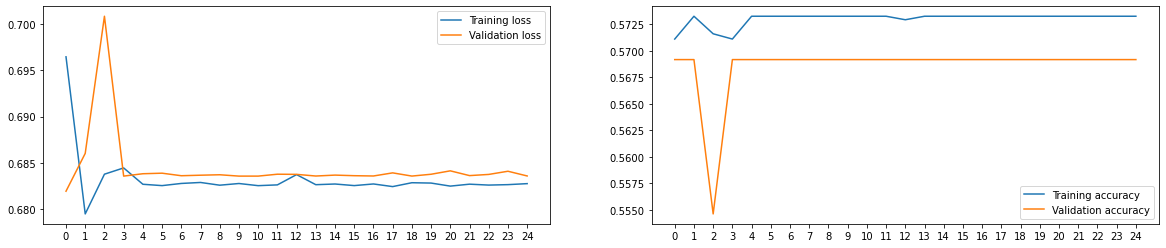

In [158]:
plt.figure(figsize = (20,4))

plt.subplot(121)
plt.xticks(np.arange(0, len(history.history['loss'])));
plt.plot(history.history['loss'], label="Training loss");
plt.plot(history.history['val_loss'], label="Validation loss");
plt.legend();

plt.subplot(122)
plt.xticks(np.arange(0, len(history.history['loss'])));
plt.plot(history.history['acc'], label="Training accuracy");
plt.plot(history.history['val_acc'], label="Validation accuracy")
plt.legend();

## Embdeddings

In [469]:
EMBEDDING_DIMENSION = 11
embedding_model = Sequential()
embedding_model.add(Embedding(UNIQUE_WORD_COUNT, EMBEDDING_DIMENSION, input_shape = (X_train.shape[1],)))
embedding_model.add(Flatten())
embedding_model.add(Dense(64, activation='relu'))
# embedding_model.add(Dropout(0.3))
embedding_model.add(Dense(64, activation='relu'))
embedding_model.add(Dense(32, activation='relu'))
embedding_model.add(Dense(16, activation='relu'))
embedding_model.add(Dense(2, activation='softmax'))

In [470]:
adam = Adam(learning_rate=0.01)
embedding_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [471]:
embedding_model.summary()

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 147, 11)           141471    
                                                                 
 flatten_31 (Flatten)        (None, 1617)              0         
                                                                 
 dense_323 (Dense)           (None, 64)                103552    
                                                                 
 dense_324 (Dense)           (None, 64)                4160      
                                                                 
 dense_325 (Dense)           (None, 32)                2080      
                                                                 
 dense_326 (Dense)           (None, 16)                528       
                                                                 
 dense_327 (Dense)           (None, 2)               

In [472]:
# early_stopping = EarlyStopping(
#     monitor='val_loss',  # Monitor validation loss
#     min_delta=0.01,  # Minimum change in monitored metric to qualify as improvement
#     patience=5,  # Number of epochs to wait for improvement before stopping
#     mode='min'  # Early stopping when monitored metric stops decreasing (for loss)
# )

history = embedding_model.fit(X_train, 
                              y_train, 
                              epochs=2, 
                              batch_size=32, 
                              validation_data=(X_val, y_val), 
                              verbose=True,
#                               callbacks=[early_stopping])
                             )

Epoch 1/2
189/189 [==============================] - 2s 4ms/step - loss: 0.6358 - acc: 0.6352 - val_loss: 0.5022 - val_acc: 0.7723
Epoch 2/2
189/189 [==============================] - 1s 3ms/step - loss: 0.3671 - acc: 0.8492 - val_loss: 0.4775 - val_acc: 0.7902


In [473]:
X_test = np.load("./X_train.npy")
X_test.shape

(3263, 147)

In [474]:
prediction = embedding_model.predict(X_test)

102/102 [==============================] - 0s 1ms/step


In [475]:
test_data = pd.read_csv("../data/test.csv")

In [476]:
ans = []
for x, y in prediction:
    if x > y:
        ans.append(0)
    else:
        ans.append(1)

In [477]:
ans_df = pd.DataFrame({'id': test_data.id,
                      'target': ans})
ans_df.to_csv("../data/final_submission_embedding.csv", index=False)

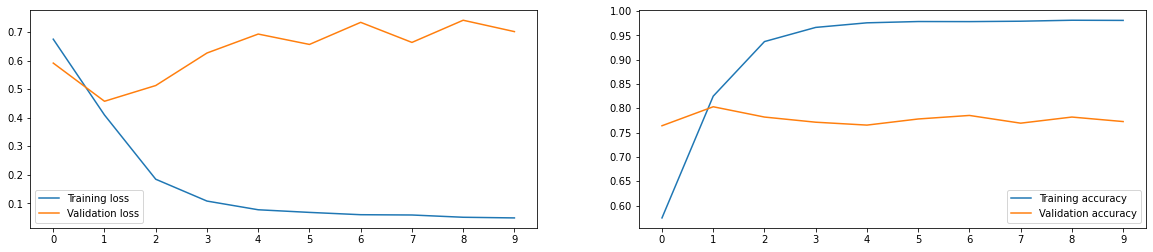

In [348]:
plt.figure(figsize = (20,4))

plt.subplot(121)
plt.xticks(np.arange(0, len(history.history['loss'])));
plt.plot(history.history['loss'], label="Training loss");
plt.plot(history.history['val_loss'], label="Validation loss");
plt.legend();

plt.subplot(122)
plt.xticks(np.arange(0, len(history.history['loss'])));
plt.plot(history.history['acc'], label="Training accuracy");
plt.plot(history.history['val_acc'], label="Validation accuracy")
plt.legend();

## Tiktoken embeddings

In [349]:
import tiktoken

In [350]:
enc = tiktoken.get_encoding("cl100k_base")

In [522]:
enc.encode(X[0])

[1336, 43607, 11987, 98492, 10033]

In [523]:
X_tiktoken = []
for i in range(len(X)):
    X_tiktoken.append(enc.encode(X[i]))

In [524]:
MAX_LEN_TIKTOKEN = max([len(x) for x in X_tiktoken])
MAX_LEN_TIKTOKEN

36

In [593]:
X_tiktoken_padded = pad_sequences(X_tiktoken, maxlen=MAX_LEN_TIKTOKEN, padding='post')
X_tiktoken_padded = np.array(X_tiktoken_padded)

In [594]:
X_tiktoken_train, X_tiktoken_val, y_tiktoken_train, y_tiktoken_val = train_test_split(X_tiktoken_padded, y_data, test_size=0.2, random_state=41)

In [583]:
X_tiktoken_train = (X_tiktoken_train - np.min(X_tiktoken_train))/(np.max(X_tiktoken_train) - np.min(X_tiktoken_train))
X_tiktoken_val = (X_tiktoken_val - np.min(X_tiktoken_val))/(np.max(X_tiktoken_val) - np.min(X_tiktoken_val))

In [485]:
tiktoken_model = Sequential()
tiktoken_model.add(Dense(1024, activation='relu', input_shape=(X_tiktoken_train.shape[1],)))
tiktoken_model.add(Dropout(0.3))
tiktoken_model.add(Dense(512, activation='relu'))
tiktoken_model.add(Dense(512, activation='relu'))
tiktoken_model.add(Dense(256, activation='relu'))
tiktoken_model.add(Dense(2, activation='softmax'))

In [486]:
adam = Adam(learning_rate=0.001)
tiktoken_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [487]:
tiktoken_model.summary()

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_328 (Dense)           (None, 1024)              37888     
                                                                 
 dropout_58 (Dropout)        (None, 1024)              0         
                                                                 
 dense_329 (Dense)           (None, 512)               524800    
                                                                 
 dense_330 (Dense)           (None, 512)               262656    
                                                                 
 dense_331 (Dense)           (None, 256)               131328    
                                                                 
 dense_332 (Dense)           (None, 2)                 514       
                                                                 
Total params: 957186 (3.65 MB)
Trainable params: 9571

In [488]:
history = tiktoken_model.fit(X_tiktoken_train, y_tiktoken_train, epochs=10, batch_size=32, 
                           validation_data=(X_tiktoken_val, y_tiktoken_val), verbose=False)

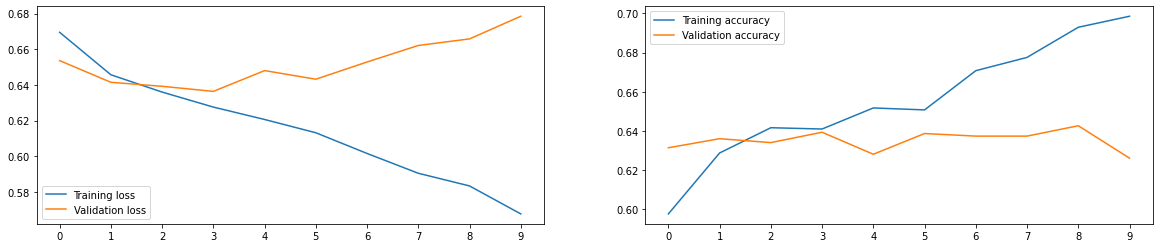

In [489]:
plt.figure(figsize = (20,4))

plt.subplot(121)
plt.xticks(np.arange(0, len(history.history['loss'])));
plt.plot(history.history['loss'], label="Training loss");
plt.plot(history.history['val_loss'], label="Validation loss");
plt.legend();

plt.subplot(122)
plt.xticks(np.arange(0, len(history.history['loss'])));
plt.plot(history.history['acc'], label="Training accuracy");
plt.plot(history.history['val_acc'], label="Validation accuracy")
plt.legend();

## Tiktoken with LSTM

In [595]:
np.max(X_tiktoken_train), np.min(X_tiktoken_train)

(100206, 0)

In [605]:
from tensorflow.keras.layers import GRU, Bidirectional
UNITS = 256

tiktoken_model_lstm = Sequential()
tiktoken_model_lstm.add(Embedding(100207, 15, input_shape=(X_tiktoken_train.shape[1], )))
tiktoken_model_lstm.add(Bidirectional(GRU(units=UNITS, return_sequences=True)))
tiktoken_model_lstm.add(Flatten())
tiktoken_model_lstm.add(Dense(128, activation='relu'))
tiktoken_model_lstm.add(Dense(32, activation='relu'))
tiktoken_model_lstm.add(Dense(8, activation='relu'))
tiktoken_model_lstm.add(Dense(2, activation='softmax'))

In [606]:
adam = Adam(learning_rate=0.001)
tiktoken_model_lstm.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

In [607]:
tiktoken_model_lstm.summary()

Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_65 (Embedding)    (None, 36, 15)            1503105   
                                                                 
 bidirectional_6 (Bidirecti  (None, 36, 512)           419328    
 onal)                                                           
                                                                 
 flatten_54 (Flatten)        (None, 18432)             0         
                                                                 
 dense_427 (Dense)           (None, 128)               2359424   
                                                                 
 dense_428 (Dense)           (None, 32)                4128      
                                                                 
 dense_429 (Dense)           (None, 8)                 264       
                                                     

In [608]:
history = tiktoken_model_lstm.fit(X_tiktoken_train, y_tiktoken_train, epochs=2, batch_size=32, 
                           validation_data=(X_tiktoken_val, y_tiktoken_val), verbose=True)

Epoch 1/2
189/189 [==============================] - 23s 103ms/step - loss: 0.5643 - acc: 0.7015 - val_loss: 0.4739 - val_acc: 0.7889
Epoch 2/2
189/189 [==============================] - 21s 111ms/step - loss: 0.3384 - acc: 0.8605 - val_loss: 0.4863 - val_acc: 0.8034
